# Wavelength Calibration without template

I will be attempting to obtain a wavelength calibration using:
- NIST lines
- Grating equation as first guess.
- _Pair Matching_ or something similar.

# Method overview

This jupyter notebook shows that is possible to obtain a good wavelength solution using information from the header, grating equation and NIST database. Roughly, the steps needed are the following. These were developed for the Goodman High Throughput Spectrograph and may differ from instrument to instrument.

1. Have a 1D comparison lamp FITS file.
2. Grab the following keywords from Image headers
   - `GRATING` (Lines per milimeter)
   - Grating Angle
   - Camera Angle
   - Binning
3. You will also need to know the pixel scale and focal length of the instrument.
4. From the grating equation you can know what the theoretical wavelength values are at the begining, middle and end,
   the pixel equivalents are easy to guess.
5. Fit a linear model using the three points
6. Create binary mask of data.
   - Remove background features, so it is flat (not done in this notebook)
   - Find the mean value.
   - Everything above the median is set to 1 and below to 0
   - Measure number of features (lines) and average width.
7. Grab list of lines from [NIST Strong Lines](https://physics.nist.gov/PhysRefData/Handbook/element_name.htm)
8. Filter the list to those within the theoretical limits
9. limit the number of lines to the number of features found the data's binary mask
10. 
11. Create binary mask of NIST strong lines
   - Use linear model's inverse to locate lines in the pixel space (array index) in this case we make sure the $\Delta\lambda$ is consistent
   - Use mean width of features in data's mask to assign width to features.
   - The relative intensity information is ignored because if differs too much from actual lamps (too many variables involved)
12. Do a global cross correlation to find initial shift
13. Do a new fit of the model using the new information
14. Use the newly fitted model to filter out NIST lines that do not correspond with any real feature in the lamp
13. Split the spectrum in N parts (for this test I used N = 12) and do local cross correlation, store the values in a list.
14. Clean the list by doing a 1-sigma clip with 2 iterations
15. Interpolate the values masked-out
16. For every NIST line find the equivalent peak in the data creating two list/arrays for pixel and wavelength values
17. Finally, do a fit of this two arrays using a non-linear model
18. Do some metrics.

## imports

In [256]:
%matplotlib notebook

from astropy import units as u
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
from ccdproc import CCDData
from itertools import combinations
from scipy import signal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.append('/user/simon/development/soar/goodman')
from pipeline.wcs.wcs import WCS

# change default size image
plt.rcParams["figure.figsize"] = [9,6]
# files
lamp_400M2_Ne = 'fits/goodman_comp_400M2_GG455_Ne.fits'


The image chosen is a 1D spectrum which contains a wavelength solution already.

In [257]:
ccd = CCDData.read(lamp_400M2_Ne, unit='adu')

[04:37:01PM][    INFO]: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


<IPython.core.display.Javascript object>


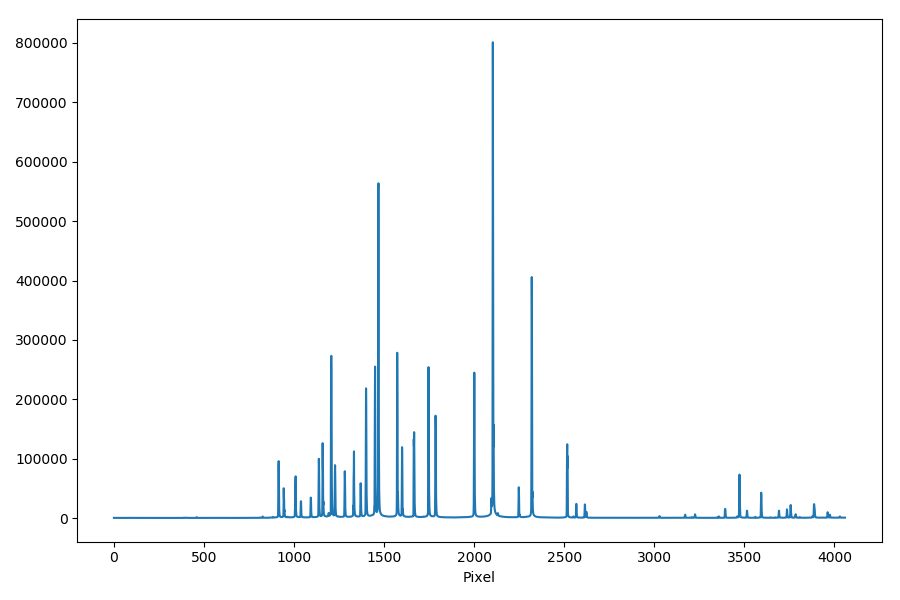

In [258]:
fig, ax = plt.subplots(num='raw_data')
ax.plot(ccd.data)
ax.set_xlabel('Pixel')
fig.tight_layout()
plt.show()

# The grating equation

$$\lambda_{central} = \frac{1e6}{GRAT} \sin\left(\frac{\alpha \pi}{180}\right) + \sin\left(\frac{\beta \pi}{180}\right)$$

In [223]:
def central_wavelength(grating, alpha, beta):
    """Returns the central wavelength"""
    return (1e6/grating) * np.sin((alpha * np.pi) / 180.) + np.sin((beta * np.pi) / 180)

In [259]:
def get_spectral_characteristics(ccd, pixel_size=15, pixel_scale=0.15, focal_length=377.3):
        """Calculates some Goodman's specific spectroscopic values.

        From the Header value for Grating, Grating Angle and Camera Angle it is
        possible to estimate what are the limits wavelength values and central
        wavelength. It was necessary to add offsets though, since the formulas
        provided are slightly off. The values are only an estimate.

        Returns:
            spectral_characteristics (dict): Contains the following parameters:
                center: Center Wavelength
                blue: Blue limit in Angstrom
                red: Red limit in Angstrom
                alpha: Angle
                beta: Angle
                pix1: Pixel One
                pix2: Pixel Two


        """
        assert isinstance(ccd, CCDData)
      
        pixel_size *= u.micrometer
        pixel_scale *= u.arcsec
        focal_length *= u.mm

        grating_frequency = float(re.sub('[A-Za-z_-]',
                                         '',
                                         ccd.header['GRATING'])) / u.mm

        grating_angle = float(ccd.header['GRT_ANG']) * u.deg
        camera_angle = float(ccd.header['CAM_ANG']) * u.deg

        serial_binning, parallel_binning = [
            int(x) for x in ccd.header['CCDSUM'].split()]

        pixel_count = len(ccd.data)

        alpha = grating_angle.to(u.rad)
        beta = camera_angle.to(u.rad) - grating_angle.to(u.rad)

        center_wavelength = (np.sin(alpha) +
                                  np.sin(beta)) / grating_frequency
        center_wavelength = center_wavelength.to(u.angstrom)

        limit_angle = np.arctan(
            pixel_count *
            (pixel_size / focal_length) / 2)

        blue_limit = ((np.sin(alpha) +
                            np.sin(beta - limit_angle.to(u.rad))) /
                           grating_frequency).to(u.angstrom) 
        
        red_limit = ((np.sin(alpha) +
                           np.sin(beta +
                                  limit_angle.to(u.rad))) /
                          grating_frequency).to(u.angstrom)

       
        spectral_characteristics = {'center': center_wavelength,
                                    'blue': blue_limit,
                                    'red': red_limit,
                                    'alpha': alpha,
                                    'beta': beta,}
        
        return spectral_characteristics

In [260]:
spec = get_spectral_characteristics(ccd=ccd)
for key in spec.keys():
    print("{:6s} : {:}".format(key, spec[key]))

center : 7001.6161656370705 Angstrom
blue   : 5001.026452363966 Angstrom
red    : 8977.974750214398 Angstrom
alpha  : 0.13090143922882672 rad
beta   : 0.15009971193491398 rad


Using the first, middle and last pixel or _blue_, _center_ and _red_ limits we define two arrays that will define a very rough wavelength solution. We use a Linear1D for simplicity, also the data that we have until now only let us go that far.

In [261]:
pixel = [0, 0.5 * len(ccd.data), len(ccd.data)]
wavelength = [spec['blue'].value, spec['center'].value, spec['red'].value]
print("Pixel Array: ")
print(pixel)
print("Wavelength Array: ")
print(wavelength)

Pixel Array: 
[0, 2030.0, 4060]
Wavelength Array: 
[5001.026452363966, 7001.6161656370705, 8977.974750214398]


Define  a `Linear1D` model and a linear fitter. And do the fit.

In [262]:
model = models.Linear1D()
fitter = fitting.LinearLSQFitter()

fitted_model = fitter(model, pixel, wavelength)
print(fitted_model)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        slope        intercept  
    -------------- -------------
    0.979543915727 5005.06497381


Reading the custom wcs method from the Goodman Pipeline

In [263]:
wcs = WCS()
gsp_ccd = wcs.read_gsp_wcs(ccd=ccd)

<IPython.core.display.Javascript object>


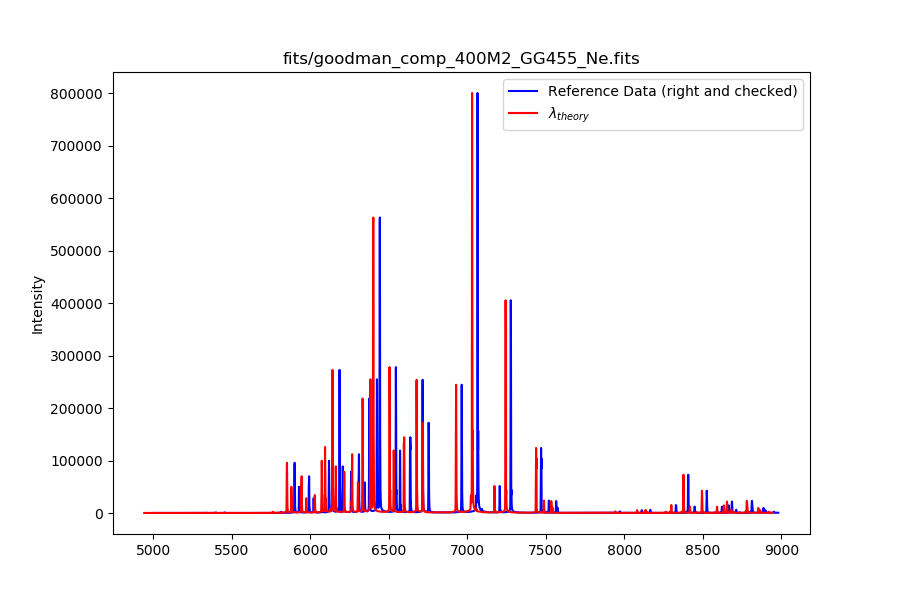

In [264]:
fig, ax = plt.subplots(num='reference-theory')
ax.set_title(lamp_400M2_Ne)
ax.plot(fitted_model(range(len(ccd.data))), ccd.data, color='b', alpha=1, label='Reference Data (right and checked)')
ax.plot(gsp_ccd[0], gsp_ccd[1], color='r', alpha=1, label='$\lambda_{theory}$')
ax.set_label("Wavelength (Angstrom)")
ax.set_ylabel('Intensity')
ax.legend()
plt.show()

There is clearly a mismatch, though it looks promising.

# Normalize and create binary mask

In the past I have tryed so many things in order to obtain a wavelength solution using information widely available and without the need of a template.

- Remove background signal (not done here because lamp is quite flat.)
- Normalize spectrum
- identify mean value

In [265]:
norm_ccd = ccd.copy()

norm_ccd.data = norm_ccd.data / norm_ccd.data.max()

data_mean = norm_ccd.data.mean()

data_mask = norm_ccd.data.copy()

data_mask[data_mask > data_mean] = 1
data_mask[data_mask <= data_mean] = 0

<IPython.core.display.Javascript object>


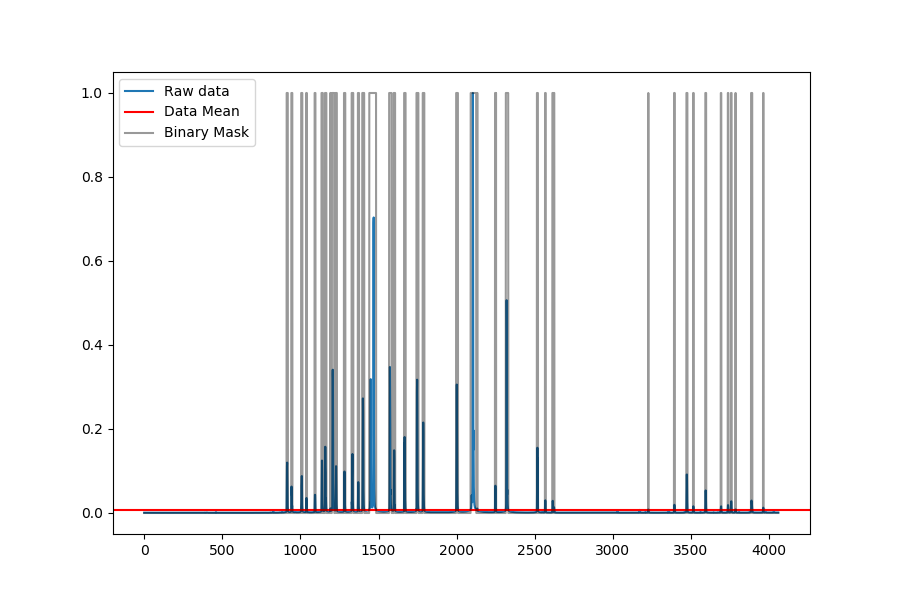

In [266]:
fig, ax = plt.subplots(num='masked-data')
ax.plot(norm_ccd.data, label='Raw data')
ax.axhline(data_mean, color='r', label='Data Mean')
ax.plot(data_mask, color='k', alpha=0.4, label='Binary Mask')
ax.legend()
plt.show()

In [232]:
def count_bars(data_mask):
    """Counts the number of bars and calculates the mean width"""
    data_mask = list(data_mask)
    
    data_mask = [' ' if e == float(0) else '1' for e in data_mask]
    str_mask = ''.join(data_mask)
    new_mask = ' '.join(str_mask.split())
#     print(new_mask.split())
    lengths = []
    for s in new_mask.split():
#         print(s)
        lengths.append(len(s))
    return len(new_mask.split()), np.mean(lengths)
        
length, mean_width = count_bars(data_mask=data_mask)
print("Number of Bars: {:d}\nMean Width: {:.0f} Pixels".format(length, mean_width))

Number of Bars: 41
Mean Width: 9 Pixels


Plotting the mask using a wavelength axis in angstrom.

<IPython.core.display.Javascript object>


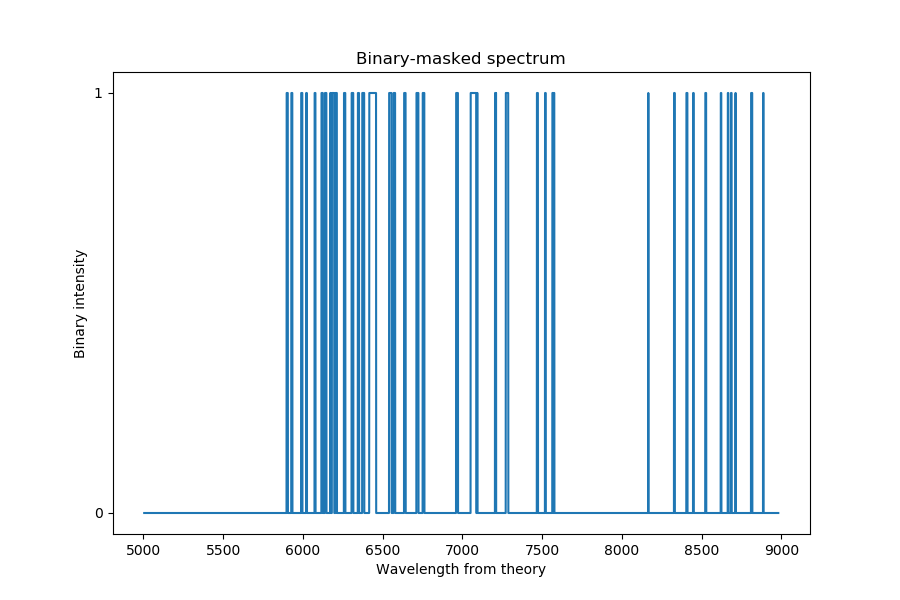

In [267]:
fig, ax = plt.subplots(num='masks-wavelength')
ax.plot(fitted_model(range(len(mask))), mask)
ax.set_title("Binary-masked spectrum")
ax.set_yticks([0, 1])
ax.set_ylabel("Binary intensity")
ax.set_xlabel("Wavelength from theory")
plt.show()

# Create binary mask of NIST lines using theoretical wavelength solution

## Note 1

I'm using the NIST lines from the Strong Lines lists.

In [268]:
nist_df = pd.read_csv('nist_list/nist_air_strong_lines_Ne.txt',
                      names=['rel_int',
                             'wavelength',
                             'ion',
                             'reference'])

Filter the lines to the theoretical wavelength limits for the instrument configuration, also sort them from largest to smallest relative intensity.

In [269]:
filtered_strong_lines = nist_df[((nist_df.wavelength > spec['blue'].value) &
                                 (nist_df.wavelength < spec['red'].value))]

sorted_strong_lines = filtered_strong_lines.sort_values('rel_int',
                                                        ascending=False)

Previusly, the number (N) of features in the data mask were counted, the list of lines from NIST will be cut the the Nth strongest lines.

In [270]:
sorted_filter_to_length_strong_lines = sorted_strong_lines[0:length].sort_values('wavelength')

print(sorted_filter_to_length_strong_lines)

           rel_int  wavelength         ion reference
190    200    P      5400.5618  Ne I            SS04
198    200    P      5852.4879  Ne I            SS04
208    100    P      6029.9969  Ne I            SS04
209    100    P      6074.3377  Ne I            SS04
212    100    P      6143.0626  Ne I            SS04
213    100    P      6163.5939  Ne I            SS04
215    100    P      6217.2812  Ne I            SS04
216    100    P      6266.4950  Ne I            SS04
220    100    P      6382.9917  Ne I            SS04
221    200    P      6402.2480  Ne I            SS04
222    150    P      6506.5281  Ne I            SS04
224    100    P      6598.9529  Ne I            SS04
228   1000    P      6929.4673  Ne I            SS04
229    300           7024.0504  Ne I            SS04
230    800    P      7032.4131  Ne I            SS04
233    800    P      7173.9381  Ne I            SS04
234    150           7213.2000  Ne II            P71
235    150           7235.1880  Ne II         

# Create mask from selected lines


It starts by creating an all-zeroes array

In [271]:
base_mask = np.zeros(len(ccd.data))

Create a linear wavelength axis using the theoretical limits. I'm not using the fitted model here is not necessary and in fact it should be equivalent.

In [272]:
base_wave = np.linspace(np.floor(spec['blue'].value), np.floor(spec['red'].value), len(ccd.data))

Obtain all the wavelength values for the NIST Lines.

In [273]:
wave_NIST = sorted_filter_to_length_strong_lines.wavelength.values

And finally add the NIST lines as features in the binary mask.

In [274]:
half_width = int((mean_width - 1)/2.)
for wave in wave_NIST:
    arg = np.argmin(np.abs(base_wave - wave))
    base_mask[arg - half_width: arg + half_width] = 1

Do a _global_ cross-correlation of the data's mask and the mask of NIST data. Remember that having the line's intensity would speed up the process but usually the relative intensities found on tables like NIST's do not have a good correlation with observed lines for many reasons. The solution is to reduce the dimension of the problem by ignoring the line intensity by using a binary mask.

In [275]:
cross_correlation = signal.correlate(base_mask, mask, mode='full')
c_index = np.argmax(cross_correlation)
cross_correlation_x_axis = np.linspace(-int(len(cross_correlation) / 2.),
                                  int(len(cross_correlation) / 2.),
                                  len(cross_correlation))
cross_correlation_value = cross_correlation_x_axis[c_index]
print("Global Cross-correlation shift: {:.1f}".format(cross_correlation_value))

Global Cross-correlation shift: -29.0


<IPython.core.display.Javascript object>


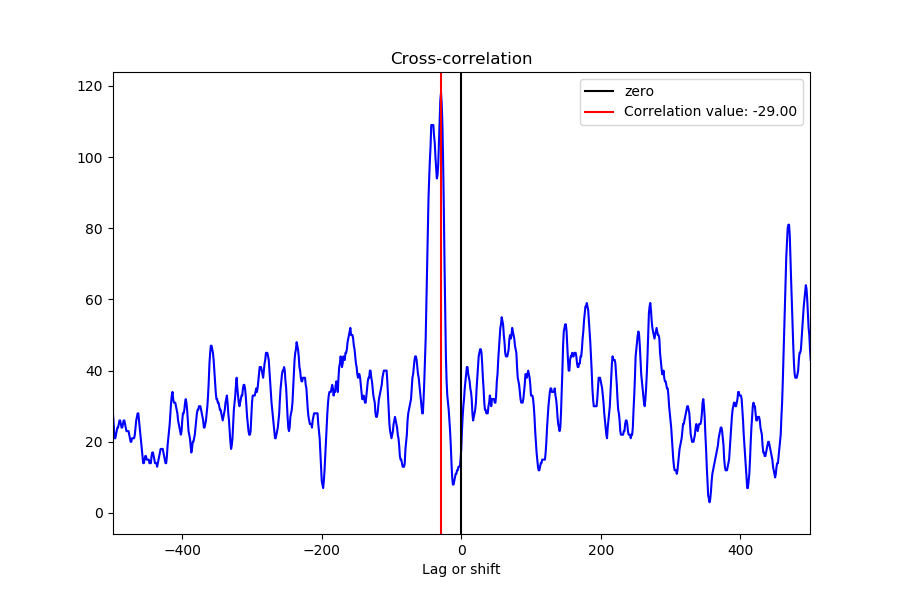

In [276]:
fig, ax = plt.subplots(num='gcross_correlation')
ax.set_title("Cross-correlation")
ax.plot(cross_correlation_x_axis, cross_correlation, color='b')
ax.axvline(0, color='k', label='zero')
ax.axvline(cross_correlation_value, color='r', label='Correlation value: {:.2f}'.format(cross_correlation_value))
ax.set_xlabel("Lag or shift")
ax.legend()
ax.set_xlim(-500, 500)
plt.show()

# So, how does it look

In prinpiple is get us closer but is not enough. Goodman data is non-linear so it has to be taken into account. The best way I have found is to 

<IPython.core.display.Javascript object>


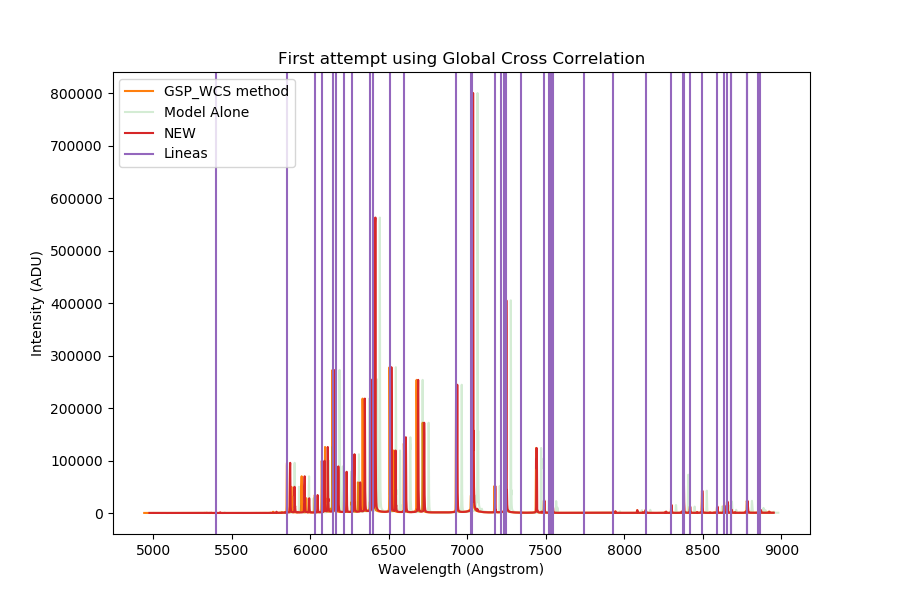

In [290]:
fig, ax = plt.subplots(num='first_attempt_global_crosscor')
ax.set_title("First attempt using Global Cross Correlation")
ax.plot(gsp_ccd[0],gsp_ccd[1], color='C1', label='GSP_WCS method')
ax.plot(fitted_model(range(len(ccd.data))), ccd.data, color='C2', label='Model Alone', alpha=0.2)
ax.plot(fitted_model(range(len(ccd.data)) + cross_correlation_value), ccd.data, color='C3', label='NEW')
ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Intensity (ADU)")

# plt.xlim(5750, 7800)
ax.plot([], color='C4', label='Lineas')
for line in wave_NIST:
    ax.axvline(line, color='C4')
ax.legend(loc='best')
plt.show()

# Considering Non-linearity of Goodman HTS data

I believe this is a good approach and now non-linearity has to enter to play. I will start by comparing both masks

<IPython.core.display.Javascript object>


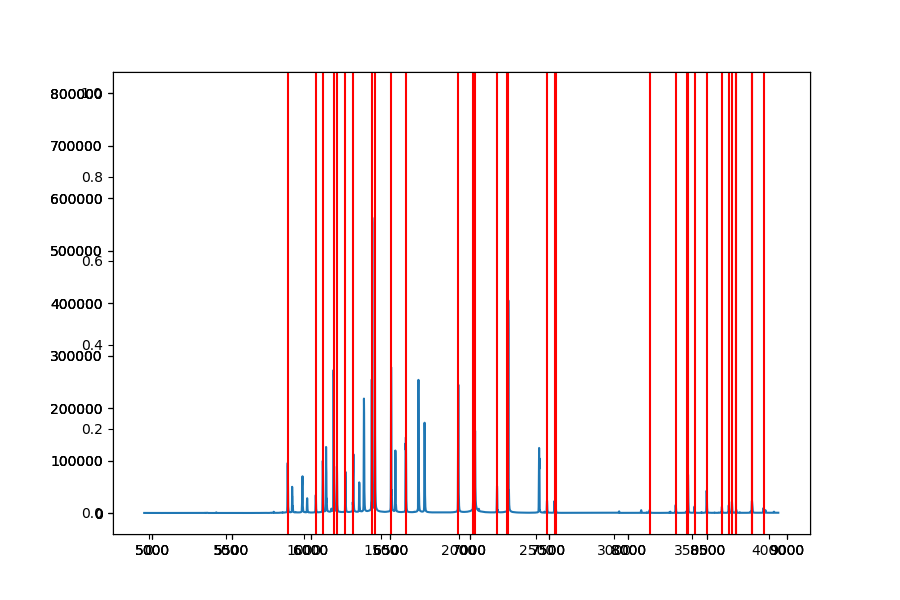

-29


In [278]:
# base_mask (NIST)
# mask (theory)

fig, ax = plt.subplots(num='comparison')

ax.plot(range(len(base_mask)), base_mask)
ax.plot(range(len(mask)) + cross_correlation_value, mask, alpha=0.4)
plt.show()
print(int(cross_correlation_value))

One thing I noticed is that in the NIST's mask there are lines that do not match the spectrum, or do not have a counterpart in the observed lamp. And they will be removed later.

First I will create a wrapper for `scipy.signal.correlate` which will return the shift value only.

In [281]:
def _cross_correlate(reference_array, new_array, mode='full'):
    """Returns the shift necessary to get maximum correlation"""
    cross_correlation = signal.correlate(reference_array, new_array, mode=mode)
    c_index = np.argmax(cross_correlation)
    cross_correlation_x_axis = np.linspace(-int(len(cross_correlation) / 2.),
                                           int(len(cross_correlation) / 2.),
                                           len(cross_correlation))
    cross_correlation_value = cross_correlation_x_axis[c_index]

    return cross_correlation_value

I'll start by defining `MAX_DIVISION` which is the amount of pieces the masks will be split in order to do cross correlations.

In [291]:
MAX_DIVISION = 12
DATA_LENGTH = len(mask)

bin_limits = range(0, DATA_LENGTH + 1, int(np.floor(DATA_LENGTH / MAX_DIVISION)))

The `bin_limits` defines where the mask will be split to either side

In [292]:
print(list(bin_limits))    

[0, 338, 676, 1014, 1352, 1690, 2028, 2366, 2704, 3042, 3380, 3718, 4056]


Now, divide each mask and do a cross correlation, which I call a _local cross correlation_ and store the offsets in a list

In [293]:
all_offsets = []
for e in range(len(bin_limits) - 1):
    new_offset = _cross_correlate(base_mask[bin_limits[e]:bin_limits[e+1]],
                                      mask[bin_limits[e]:bin_limits[e+1]])
    all_offsets.append(new_offset)

print(all_offsets)

[-337.0, -337.0, -140.0, -43.0, -39.0, -36.0, -36.0, -29.0, -337.0, -30.0, -29.0, -30.0]


We can see that there are some values way off wich will be eliminated using a 1-sigma clipping with two iterations

In [295]:
clipped_offset = sigma_clip(all_offsets, sigma=1, iters=2)
print(clipped_offset)

[-- -- -- -43.0 -39.0 -36.0 -36.0 -29.0 -- -30.0 -29.0 -30.0]


The masked values will have to be filled in order to improve the fit. I will be using a second order polinomial.

In [345]:
# print(clipped_offset)
x_axis = [i for i in range(len(clipped_offset.mask)) if clipped_offset.mask[i] == False]
y_axis = [clipped_offset[i] for i in range(len(clipped_offset)) if clipped_offset.mask[i] == False]

masked_index = [i for i in range(len(clipped_offset.mask)) if clipped_offset.mask[i] == True]


poly = models.Polynomial1D(degree=2)
fitter = fitting.LevMarLSQFitter()
fitted_poly = fitter(poly, x_axis, y_axis)
print(fitted_poly)


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
          c0             c1             c2      
    -------------- ------------- ---------------
    -58.3959037956 6.02118564449 -0.311208192409


<IPython.core.display.Javascript object>


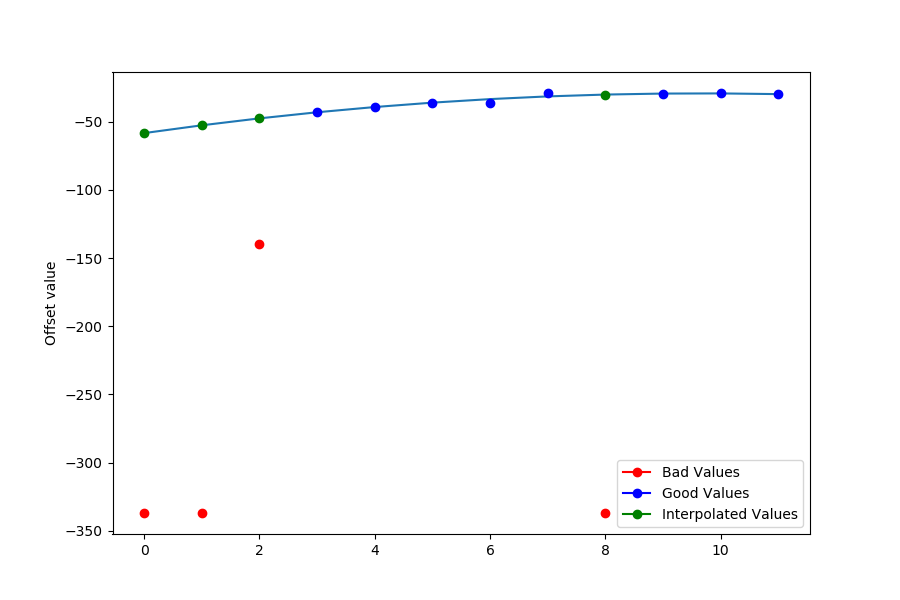

0 -58.39590379556557
1 -52.68592634347989
2 -47.59836527621195
8 -30.143742953776776


In [359]:
fig, ax = plt.subplots(num='clipped')
ax.plot(range(len(clipped_offset)), fitted_poly(range(len(clipped_offset))))
ax.plot([], color='r', marker='o', label='Bad Values')
ax.plot([], color='b', marker='o', label='Good Values')
ax.plot([], color='g', marker='o', label='Interpolated Values')
for e in masked_index:
    print(e, fitted_poly(e))
    ax.plot(e, fitted_poly(e), marker='o', color='g')
for i in range(len(clipped_offset)):
    
    if clipped_offset.mask[i]:
        ax.plot(i, all_offsets[i], marker='o', color='r')
    else:
        ax.plot(i, clipped_offset[i], marker='o', color='b')
ax.set_ylabel('Offset value')
ax.set_xlabel('')
ax.legend()
plt.show()

In [363]:
final_offsets = [clipped_offset[i] if clipped_offset.mask[i] == False else fitted_poly(i) for i in range(len(clipped_offset)) ]
print(final_offsets)

[-58.39590379556557, -52.68592634347989, -47.59836527621195, -43.0, -39.0, -36.0, -36.0, -29.0, -30.143742953776776, -30.0, -29.0, -30.0]


It seems to me that fitting a second order polynomial should help to interpolate the missing values.

In [368]:
angstrom = wave_NIST
pixel = fitted_model.inverse(angstrom)

for e in range(len(bin_limits) - 1):
    for z in range(len(angstrom)):
        if bin_limits[e] < pixel[z] < bin_limits[e + 1]:
            pixel[z] = pixel[z] - final_offsets[e]
print(pixel, len(pixel))
                

[  456.44202123   912.71825687  1089.33586073  1134.60264182  1204.76274276
  1225.72280353  1280.53127014  1330.77281542  1445.70234796  1465.36078256
  1571.81859249  1666.17352494  2000.59014781  2097.14845263  2105.68579319
  2250.16629859  2290.24811561  2312.69529705  2322.88228289  2416.72349931
  2564.6762329   2599.33195323  2612.55861902  2621.00152788  2822.94657932
  3012.28265402  3226.73306721  3423.07666188  3466.35586749  3471.97276726
  3513.64460999  3592.1836104   3690.08488717  3764.37958321  3755.5278376
  3781.16160408  3783.6409212   3884.4036317   3887.59971097  3959.17741042
  3971.31407914] 41


In [369]:
# pixel[0] = fitted_model.inverse(angstrom[0])+45
# pixel[1] = fitted_model.inverse(angstrom[1])+45
# pixel[24] = fitted_model.inverse(angstrom[24])+29
# # pixel[25] = fitted_model.inverse(angstrom[25])+30
# for e in masked_index:
#     pixel[e] = fitted_model.inverse(angstrom[0]) - fitted_poly(e)
# # print(pixel)
from astropy.modeling import (models, fitting)

model = models.Chebyshev1D(degree=3)
print(fitted_model)

model.c0.value = fitted_model.intercept.value
# model.c0.fixed = True

model.c1.value = fitted_model.slope.value
# model.c1.fixed = True

fitter = fitting.LevMarLSQFitter()

new_fitted_model = fitter(model, pixel, angstrom)

print(new_fitted_model)
print("GSP_WCS Model")
print(wcs.model)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        slope        intercept  
    -------------- -------------
    0.979543915727 5005.06497381
Model: Chebyshev1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
          c0            c1              c2                 c3       
    ------------- ------------- ------------------ -----------------
    4942.48053804 1.00268449114 -2.62840179724e-06 8.28714532929e-11
GSP_WCS Model
Model: Chebyshev1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
          c0            c1               c2                c3        
    ------------- -------------- ----------------- ------------------
    4943.30908102 0.993456357202 3.88788220549e-07 -1.55420966577e-10


<IPython.core.display.Javascript object>


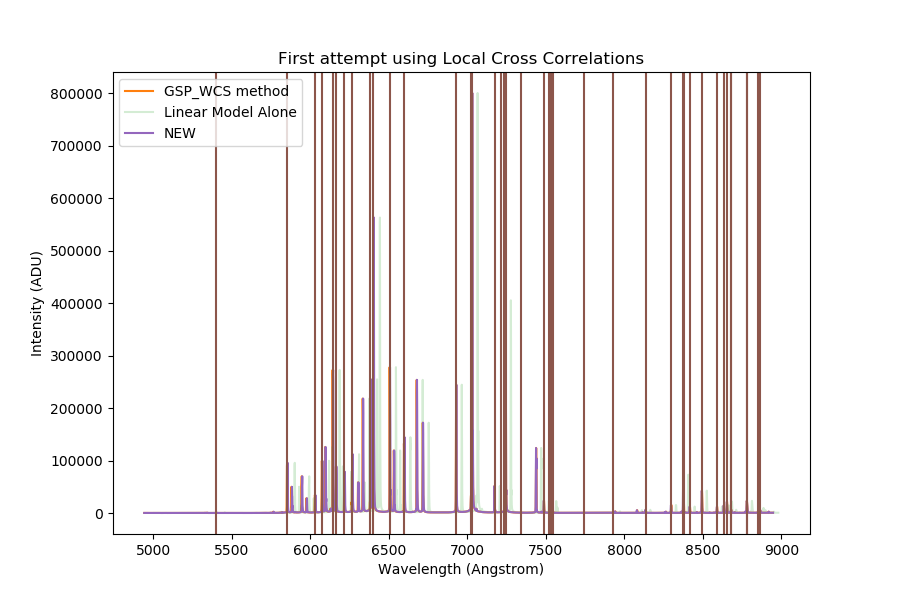

In [370]:
fig, ax = plt.subplots(num='local-correlations')
ax.set_title("First attempt using Local Cross Correlations")
ax.plot(gsp_ccd[0],gsp_ccd[1], color='C1', label='GSP_WCS method')
ax.plot(fitted_model(range(len(ccd.data))), ccd.data, color='C2', label='Linear Model Alone', alpha=0.2)
# plt.plot(new_fitted_model(range(len(ccd.data))), ccd.data, color='C3', label='New Model Alone', alpha=0.2)
ax.plot(new_fitted_model(range(len(ccd.data))), ccd.data, color='C4', label='NEW')
ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Intensity (ADU)")
ax.legend(loc='best')
# plt.xlim(5750, 7800)
for line in wave_NIST:
    ax.axvline(line, color='C5')

plt.show()

<IPython.core.display.Javascript object>


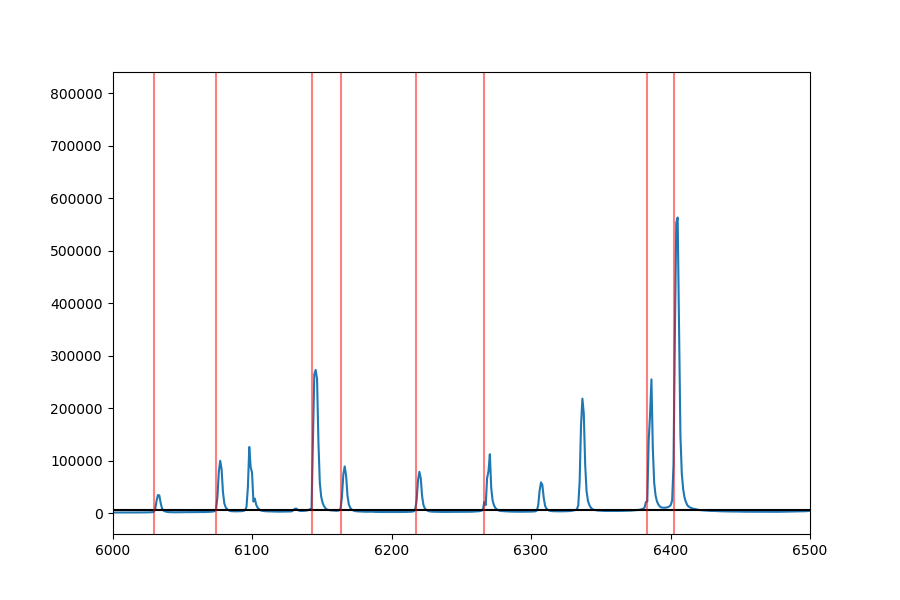

In [371]:

copy_wave_nist = wave_NIST.copy()

data_mean = np.mean(ccd.data)

wavelength_axis = new_fitted_model(range(len(ccd.data)))
cleaned_lines = []
for line in wave_NIST:
    pix = int(np.argmin(abs(wavelength_axis - line)))
#     pix = int(new_fitted_model.inverse(line))
    if np.max(ccd.data[pix-10:pix+10]) < data_mean:
#         plt.axvline(line, color='m')
        pass
    else:
#         plt.axvline(line, color='r')
        cleaned_lines.append(line)

fig, ax = plt.subplots(num='cleaned_lines')
ax.plot(new_fitted_model(range(len(ccd.data))), ccd.data)
ax.axhline(data_mean, color='k')
for line in cleaned_lines:
    ax.axvline(line, color='r', alpha=.5)
ax.set_xlim(6000, 6500)
plt.show()

In [372]:
pixels = []
for line in cleaned_lines:
    index = int(np.argmin(abs(wavelength_axis - line)))
    low = np.max([0, index - 10])
    high = np.min([index + 10, len(ccd.data)])
#     plt.axvspan(new_fitted_model(low), new_fitted_model(high), color='g', alpha=0.3)
    pix = int(np.argmax(ccd.data[low:high]))
    pixels.append(index + pix - 10)
#     pix_val = range()
#     print(index, index + pix -10, pix-10)
#     plt.axvline(new_fitted_model(index + pix -10))

<IPython.core.display.Javascript object>


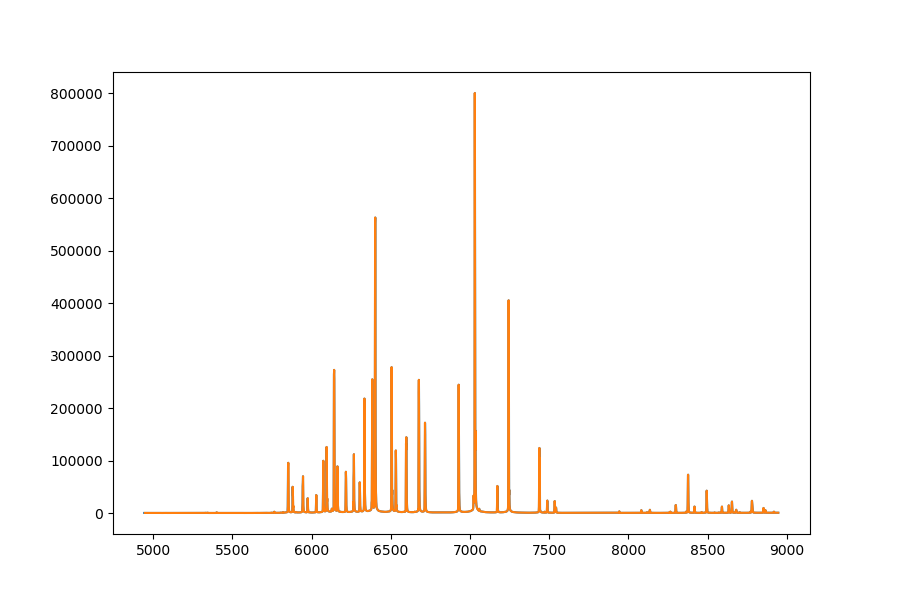

In [376]:

fitted_2_model = fitter(new_fitted_model, pixels, cleaned_lines)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(gsp_ccd[0], gsp_ccd[1], label='GSP_WCS')
ax.plot(fitted_2_model(range(len(ccd.data))), ccd.data, label='New')
# ax.set_xlim(5800, 6400)
plt.show()


# Metrics
The general idea is to estimate the residuals, but is not so simple to just subtract them. So I will try using interpolation

In [381]:
import scipy

def interpolate(x_axis, intensity):
    
    new_x_axis = np.linspace(spec['blue'], spec['red'], len(intensity))
    
    tck = scipy.interpolate.splrep(x_axis, intensity, s=0)
    new_intensity = scipy.interpolate.splev(new_x_axis, tck, der=0)
    
    return new_x_axis, new_intensity

x_ref, i_ref = interpolate(x_axis=gsp_ccd[0], intensity=gsp_ccd[1])
x_new, i_new = interpolate(x_axis=fitted_2_model(range(len(ccd.data))), intensity=ccd.data)

<IPython.core.display.Javascript object>


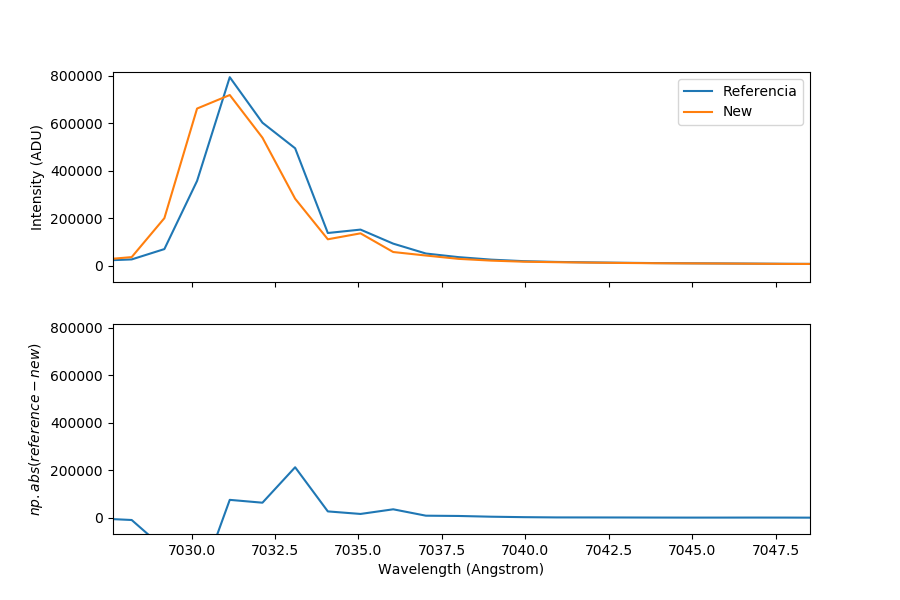

In [392]:
fig, (ax1, ax2) = plt.subplots(2, 1, num='interpolated', sharex=True, sharey=True)
ax1.plot(x_ref, i_ref, label='Referencia')
ax1.plot(x_new, i_new, label='New')
ax1.set_ylabel('Intensity (ADU)')
ax1.legend()
ax2.plot(x_ref, i_ref - i_new, label='Residuals')
ax2.set_ylabel('$np.abs(reference - new)$')
ax2.set_xlabel('Wavelength (Angstrom)')
plt.show()

# Compare result with NIST Lines

<IPython.core.display.Javascript object>


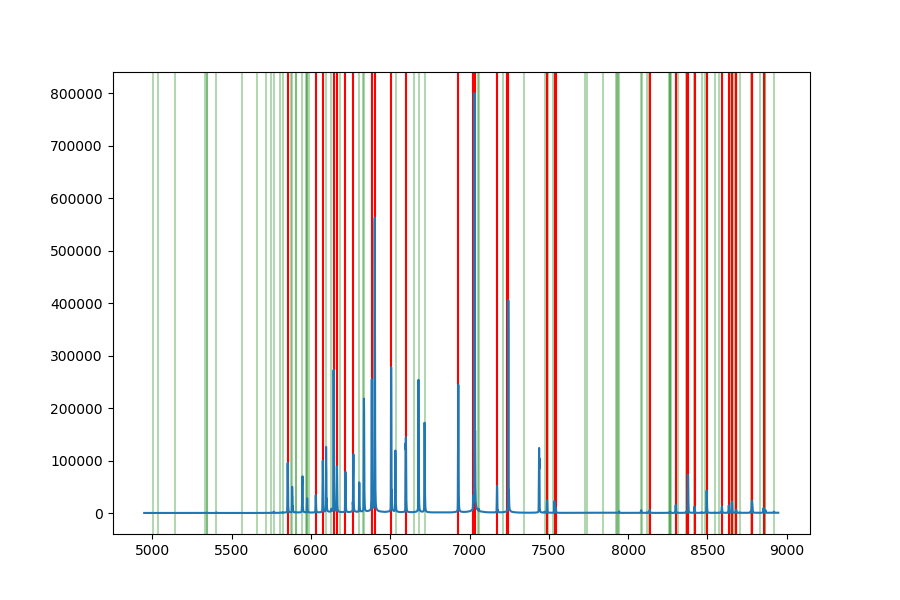

In [405]:
# print(filtered_strong_lines.wavelength.values)
fig, ax = plt.subplots(num='comparisossn')
for nist_line in filtered_strong_lines.wavelength.values:
    ax.axvline(nist_line, color='g', alpha=0.3)
for line in cleaned_lines:
    ax.axvline(line, color='r')
ax.plot(fitted_2_model(range(len(ccd.data))), ccd.data, label='New')
plt.show()

# possible ways to improve

- re-identify matching lines in NIST using 
- re-fit

- MAXDIV = %2, %5
- array1, array2 | cat_array, obs_array
- fig, ax = plt.subplots(num='aaaa')
- metrica (rms)